In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

## Notebook 2 - EDA

This is the second of 3 notebooks for this project.

In this notebook, I will:
- Preprocess the title text data using lemmitization and removal of stop words
- Explore the popular unigrams, bigrams and trigrams each of The Onion posts and Not The Onion posts
- Explore author vs post distribution and domain vs post distribution for each subreddit
- Compare some features between the 2 subreddits
- Export data to be used in the final notebook

----
## Load Data

In [2]:
theonion_df = pd.read_csv('../data/the_onion.csv')
nottheonion_df = pd.read_csv('../data/not_the_onion.csv')

Find out what are the extra columns in the theonion dataframe.

In [3]:
extra_columns = []
for column in theonion_df.columns:
    if column not in nottheonion_df.columns:
        extra_columns.append(column)
        
extra_columns

['gallery_data', 'is_gallery', 'media_metadata']

The 3 extra columns are related to the gallery and media metadata, which will not affect text analysis.

Due to the engineer's mistake we can only use the title text to train the machine learning model. Hence, check for any missing values in the title columns of the datasets.

In [4]:
theonion_df['title'].isnull().sum()

0

In [5]:
nottheonion_df['title'].isnull().sum()

0

No missing values in the title column for either dataset.

----
## Preprocessing the text

Define a function to lemmatize, remove stopwords and remove punctuation.

In [6]:
def lemmatize(text):
    #Match a-z, A-Z, 0-9, _
    tokenizer = RegexpTokenizer(r'\w+')
    title_tokens = tokenizer.tokenize(text)
    #As stop words are all in lower case, convert tokens to lower case to match them to stop words later 
    title_tokens = [token.lower() for token in title_tokens]
    lemmatizer = WordNetLemmatizer()
    #Match and remove stop words, then lemmatize
    lem_tokens = [lemmatizer.lemmatize(i) for i in title_tokens if i not in stopwords.words('english')]
    #Join lemmatized tokens with a space in between, back into a sentence. Also converts all tokens to lower case. 
    return(" ".join(lem_tokens)).lower()

Test the function on a random string of text that contains stopwords and punctuation.

In [7]:
lemmatize('A quick brown a fox computer 9 feet..')

'quick brown fox computer 9 foot'

**Observations on function output:**
- Function removed "a", which is a stopword and also "." which is a punctuation.
- Function kept the number "9".
- Function lemmatized "feet" into "foot".
- Function is working as intended.

Apply function to the reddit posts' titles.

In [8]:
theonion_df['lem_title'] = theonion_df['title'].apply(lemmatize)

In [9]:
theonion_df[['title','lem_title']].head()

,title,lem_title
0,abby lee miller has cancer,abby lee miller cancer
1,Amazon Celebrates Union Defeat By Raising All Prices 150% Anyway,amazon celebrates union defeat raising price 150 anyway
2,New Arkansas Bill Would Require Teen Residents To Keep Genitals On Full Display At All Times,new arkansas bill would require teen resident keep genitals full display time
3,‘No Way To Prevent This.’ Says Only Nation Where This Regularly Happens,way prevent say nation regularly happens
4,"Panthers Adopt Patchy-Haired, Shivering Rescue QB Who Spent Years Abused By Jets",panther adopt patchy haired shivering rescue qb spent year abused jet


In [10]:
nottheonion_df['lem_title'] = nottheonion_df['title'].apply(lemmatize)

In [11]:
nottheonion_df[['title','lem_title']].head()

,title,lem_title
0,Kanye West Jumped Into Swan Lake in the Middle of His Free Concert,kanye west jumped swan lake middle free concert
1,Ex-Versace model credits youthful looks to drinking his own urine,ex versace model credit youthful look drinking urine
2,"What else is he supposed to do against all those vicious, bloodthirsty Ukrainians",else supposed vicious bloodthirsty ukrainian
3,Superyacht building boom creates a supply crunch and crew shortage for ultrarich buyers,superyacht building boom creates supply crunch crew shortage ultrarich buyer
4,Barrister who sued after colleague asked him to stop farting loses case,barrister sued colleague asked stop farting loses case


----
## Most common n-grams for The Onion Subreddit

Text(0.5, 1.0, 'Most popular unigram for The Onion Subreddit')

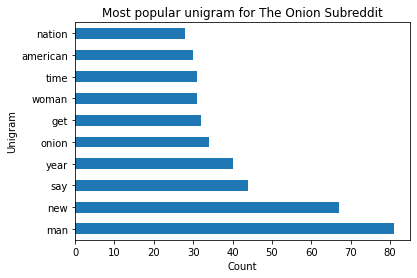

In [12]:
cvec = CountVectorizer()
the_onion_lem_title = cvec.fit_transform(theonion_df['lem_title'])
the_onion_lem_title_df = pd.DataFrame(the_onion_lem_title.toarray(), columns = cvec.get_feature_names())
the_onion_lem_title_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.ylabel('Unigram')
plt.xlabel('Count')
plt.title('Most popular unigram for The Onion Subreddit')

Text(0.5, 1.0, 'Most popular bigram for The Onion Subreddit')

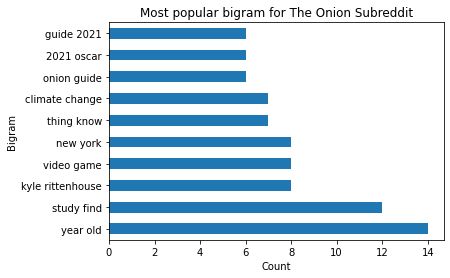

In [13]:
cvec_bi = CountVectorizer(ngram_range=(2,2))
the_onion_lem_title_bi = cvec_bi.fit_transform(theonion_df['lem_title'])
the_onion_lem_title_bi_df = pd.DataFrame(the_onion_lem_title_bi.toarray(), columns = cvec_bi.get_feature_names())
the_onion_lem_title_bi_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.ylabel('Bigram')
plt.xlabel('Count')
plt.title('Most popular bigram for The Onion Subreddit')

The Onion covers both real and fictional events and present them as satire. 

In [14]:
theonion_df.loc[theonion_df['lem_title'].str.contains('guide 2021') ,['title']]

,title
140,The Onion’s Guide To The 2021 Oscars
156,The Onion’s Guide To The 2021 Oscars: Best Actor
157,The Onion’s Guide To The 2021 Oscars: Best Actress
162,The Onion’s Guide To The 2021 Oscars: Best Supporting Actress
163,The Onion’s Guide To The 2021 Oscars: Best Supporting Actor
164,The Onion’s Guide To The 2021 Oscars: Best Director


In [15]:
theonion_df.loc[theonion_df['lem_title'].str.contains('2021 oscar') ,['title']]

,title
140,The Onion’s Guide To The 2021 Oscars
156,The Onion’s Guide To The 2021 Oscars: Best Actor
157,The Onion’s Guide To The 2021 Oscars: Best Actress
162,The Onion’s Guide To The 2021 Oscars: Best Supporting Actress
163,The Onion’s Guide To The 2021 Oscars: Best Supporting Actor
164,The Onion’s Guide To The 2021 Oscars: Best Director


In [16]:
theonion_df.loc[theonion_df['lem_title'].str.contains('onion guide') ,['title']]

,title
140,The Onion’s Guide To The 2021 Oscars
156,The Onion’s Guide To The 2021 Oscars: Best Actor
157,The Onion’s Guide To The 2021 Oscars: Best Actress
162,The Onion’s Guide To The 2021 Oscars: Best Supporting Actress
163,The Onion’s Guide To The 2021 Oscars: Best Supporting Actor
164,The Onion’s Guide To The 2021 Oscars: Best Director


**Observation:** 3 sets of bigrams "guide 2021", "2021 oscar" and "onion guide" come from the same set of 6 reddit posts on the 2021 oscars.

In [17]:
theonion_df.loc[theonion_df['lem_title'].str.contains('climate change') ,['title']]

,title
153,"‘Anyone See ‘Ted Lasso’?’ Biden Asks World Leaders, Trying To Steer Conversation Away From Depressing Topic Like Climate Change"
461,Senate Passes Bill Wishing Younger Generations Best Of Luck Stopping Climate Change
512,Latest Climate Change Report Just Heartfelt Farewell Letter Telling Humanity To Remember The Good Times
564,New Study Finds Only Way To Reverse Climate Change If Every Person On Earth Shares Single Chevy Volt
609,Polar Bears Inbreeding Due To Climate Change
907,Albatross divorce rates going up due to climate change
963,Study: Climate Change Causing Albatross ‘Divorce’


In [18]:
theonion_df.loc[theonion_df['lem_title'].str.contains('thing know') ,['title']]

,title
38,5 Things To Know About ‘Hemingway’
43,5 Things To Know About ‘Godzilla Vs. Kong’
109,5 Things To Know About Liz Cheney
203,5 Things To Know About ‘Friends: The Reunion’
266,5 Things To Know About ‘The Underground Railroad’
357,5 Things To Know About ‘Cruella’
363,5 Things To Know About Belarus’ Leader Diverting A Ryanair Flight


**Observation:** The bigram "thing know" comes from a series of posts on "5 things to know about X"

In [19]:
theonion_df.loc[theonion_df['lem_title'].str.contains('new york') ,['title']]

,title
51,Andrew Cuomo Announces Extension Of Vaccine Eligibility To All New Yorkers 30DD And Above
282,Andrew Yang Picking Up A Few Souvenirs On Way Back Home From New York Visit
397,6-Year-Old Debating Whether To See ‘Space Jam: A New Legacy’ Following Negative ‘New York Times’ Review
449,Blood-Soaked Mayor Bloomberg Announces Homelessness No Longer A Problem In New York City
481,Historical Evidence Suggests Boston Strangler Too Chickenshit To Strangle In A Real City Like New York
505,"‘Take Your Place By My Side And We Can Rule New York Forever,’ Says Covid To Disgraced, Vengeful Andrew Cuomo"
615,Country Music Stars Challenge Al-Qaeda with Patriotic New Song 'Bomb New York'
674,‘New York Times’ Releases Jerry Jones’ Hateful Telegrams Slamming Ottoman Empire
773,‘New York Times’ Copy Editor Recommends Tom Morello Cut Down Use Of Wah-Wah Pedal In Column


**Observation:** The posts containing the bigram "new york" cover various topics on New York city and do not really have any relations to each other.

In [20]:
theonion_df.loc[theonion_df['lem_title'].str.contains('video game') ,['title']]

,title
54,The Most Insane Quotes We Heard About Video Games In Winter 2021
124,Deal Alert: Any Video Game At Any Price Is Inherently An Incredible Deal Because Video Games Are Great
428,Video Game Boss Thinking He Should Get Big Glowing Weak Spot On Back Checked Out
433,Guard In Video Game Under Strict Orders To Repeatedly Pace Same Stretch Of Hallway
590,Are Violent Video Games Preparing Kids For The Apocalypse?
660,Video Game Character Reckoning With Privilege Of Dropping Near Tactical Shotgun
797,Josh Hawley Slams Video Games As Threat To American Masculinity After Bullshit Sniper Ends His ‘Battlefield’ Killstreak


**Observation:** The posts containing the bigram "video game" cover various topics on video games and do not really have any relations to each other.

In [21]:
theonion_df.loc[theonion_df['lem_title'].str.contains('kyle rittenhouse') ,['title']]

,title
769,Critics Question Why Kyle Rittenhouse Singled Out In Kyle Rittenhouse Trial
815,Kyle Rittenhouse Claims Self-Defense After Shooting 3 Jurors
831,"Men Killed By Kyle Rittenhouse Can Be Called ‘Looters,’ Not ‘Victims,’ Judge Rules"
844,Judge Mandates Prosecutors Only Refer To Kyle Rittenhouse As ‘Hero’
925,Kyle Rittenhouse Acquitted Of All Charges In Kenosha Shootings
928,Kyle Rittenhouse Sentenced To 45 Years Of CPAC Appearances
929,"‘Order, Order,’ Shouts Judge In Kyle Rittenhouse Case While Shooting AR-15 At Ceiling"


**Observation:** The posts containing the bigram "kyle rittenhouse" cover the Kenosha unrest shooting that happened on August 25, 2020. In this incident, a 17 year old Kyle Rittenhouse fatally shot 2 men and wounded another in Kenosha, Wisconsin. The shooting happened during a period of civil unrest caused by the non-fatal shooting of a black man called Jacob Blake. Kyle Rittenhouse was acquitted of all charges after pleading self-defense.

In [22]:
theonion_df.loc[theonion_df['lem_title'].str.contains('study find') ,['title']]

,title
180,Study Finds Universal Mask Use Could Cut U.S. Coronavirus Deaths By 67%
297,Study Finds American Women Delaying Motherhood Because The Whole Thing Blows
403,"Study Finds 70% Of Americans Have Less Than $1,000 Saved To Go To Space"
439,New Study Finds 85% Of Americans Don't Know All The Dance Moves To National Anthem
506,Study Finds No Greater Sign Of Delusion Than Sending Coworkers Your Personal Email On Last Day
564,New Study Finds Only Way To Reverse Climate Change If Every Person On Earth Shares Single Chevy Volt
579,Study Finds First 72 Hours Crucial To Determining Whether Missing Person Case Goes Viral
586,New Madden ‘Owner Mode’ Allows Players To Customize Concussion Study Findings
592,Study Finds Virus Frequently Fooled By Fake Vaccine Card
593,Study finds virus frequently fooled by fake vaccine card


**Observation:** The posts containing the bigram "study find" cover various topics in the popular format of a study finding something interesting/satirical. The posts generally have no relation to each other.

In [23]:
theonion_df.loc[theonion_df['lem_title'].str.contains('year old') ,['title']]

,title
13,17-Year-Old Asks Friend What It Means When Guy You Like Wants Blanket Pardon
196,7-Year-Old Has Seen Way Deeper Deep Ends
275,Pathetic Man Cries When He’s Upset Rather Than Screaming At 3-Year-Old Son To Shut The Fuck Up
360,11-Year-Old Used ‘SVU’ Tip To Mark Attacker
397,6-Year-Old Debating Whether To See ‘Space Jam: A New Legacy’ Following Negative ‘New York Times’ Review
426,Congress Cuts Funding For 26-Year-Old Stepson
561,5-Year-Old Announces Circle No Longer Her Favorite Shape
638,U.S. Airstrike Sends Tough Message To 4-Year-Old Afghans Not To Mess With America
710,40-Year-Old Not Active Enough To Realize Body Falling Apart
712,Soaring U.S. Divorce Rate Blamed On Local 11-Year-Old


**Observation:** The posts containing the bigram "year old" cover various topics that mention the age of people. They generally have no relation to each other.

Text(0.5, 1.0, 'Most popular trigram for The Onion Subreddit')

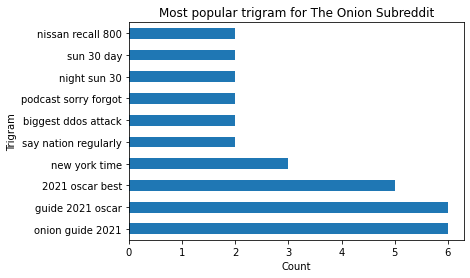

In [24]:
cvec_tri = CountVectorizer(ngram_range=(3,3))
the_onion_lem_title_tri = cvec_tri.fit_transform(theonion_df['lem_title'])
the_onion_lem_title_tri_df = pd.DataFrame(the_onion_lem_title_tri.toarray(), columns = cvec_tri.get_feature_names())
the_onion_lem_title_tri_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.ylabel('Trigram')
plt.xlabel('Count')
plt.title('Most popular trigram for The Onion Subreddit')

In [25]:
theonion_df.loc[theonion_df['lem_title'].str.contains('nissan recall 800') ,['title']]

,title
90,Nissan recalls 800 000 Sentras over brake lights - Car News. Car Reviews
91,"Nissan recalls 800,000 Sentras over brake lights, as if things couldn't get any worse."


**Observation:** The posts containing the trigram "nissan recall 800" are covering how Nissan recalled 800,000 Sentras over brake light issues.

In [26]:
theonion_df.loc[theonion_df['lem_title'].str.contains('sun 30 day') ,['title']]

,title
430,Man wakes up at night with the sun up for 30 days. The results will shock you.
431,Man wakes up at night with the sun up for 30 days. The results will shock you


**Observation:** The posts containing the trigram "sun 30 day" are covering the same topic.

In [27]:
theonion_df.loc[theonion_df['lem_title'].str.contains('podcast sorry forgot') ,['title']]

,title
318,"🎉Happy birthday🎉 to Leslie Price, host of Onion Public Radio's ""The Topical"" podcast. Sorry we forgot your birthday last June 8th"
319,"🎉Happy birthday🎉 to Lesley Price, host of Onion Public Radio's ""The Topical"" podcast. Sorry we forgot your birthday last June 8th"


**Observation:** The posts containing the trigram "podcast sorry forgot" are covering the same topic.

In [28]:
theonion_df.loc[theonion_df['lem_title'].str.contains('biggest ddos attack') ,['title']]

,title
702,Facebook Outage: Biggest DDOS Attack in History Facebook Outage: Biggest DDOS Attack in History


**Observation:** There is only 1 post containing the trigram "biggest ddos attack" but the trigram appears twice.

In [29]:
theonion_df.loc[theonion_df['lem_title'].str.contains('say nation regularly') ,['title']]

,title
3,‘No Way To Prevent This.’ Says Only Nation Where This Regularly Happens
62,"‘No Way To Prevent This,’ Says Only Nation Where This Regularly Happens"


**Observation:** The posts containing the trigram "say nation regularly" are covering the same topic.

In [30]:
theonion_df.loc[theonion_df['lem_title'].str.contains('new york time') ,['title']]

,title
397,6-Year-Old Debating Whether To See ‘Space Jam: A New Legacy’ Following Negative ‘New York Times’ Review
674,‘New York Times’ Releases Jerry Jones’ Hateful Telegrams Slamming Ottoman Empire
773,‘New York Times’ Copy Editor Recommends Tom Morello Cut Down Use Of Wah-Wah Pedal In Column


**Observation:** The posts containing the trigram "new york time" are parodying the New York Times.

In [31]:
theonion_df.loc[theonion_df['lem_title'].str.contains('2021 oscar best') ,['title']]

,title
156,The Onion’s Guide To The 2021 Oscars: Best Actor
157,The Onion’s Guide To The 2021 Oscars: Best Actress
162,The Onion’s Guide To The 2021 Oscars: Best Supporting Actress
163,The Onion’s Guide To The 2021 Oscars: Best Supporting Actor
164,The Onion’s Guide To The 2021 Oscars: Best Director


In [32]:
theonion_df.loc[theonion_df['lem_title'].str.contains('guide 2021 oscar') ,['title']]

,title
140,The Onion’s Guide To The 2021 Oscars
156,The Onion’s Guide To The 2021 Oscars: Best Actor
157,The Onion’s Guide To The 2021 Oscars: Best Actress
162,The Onion’s Guide To The 2021 Oscars: Best Supporting Actress
163,The Onion’s Guide To The 2021 Oscars: Best Supporting Actor
164,The Onion’s Guide To The 2021 Oscars: Best Director


In [33]:
theonion_df.loc[theonion_df['lem_title'].str.contains('onion guide 2021') ,['title']]

,title
140,The Onion’s Guide To The 2021 Oscars
156,The Onion’s Guide To The 2021 Oscars: Best Actor
157,The Onion’s Guide To The 2021 Oscars: Best Actress
162,The Onion’s Guide To The 2021 Oscars: Best Supporting Actress
163,The Onion’s Guide To The 2021 Oscars: Best Supporting Actor
164,The Onion’s Guide To The 2021 Oscars: Best Director


**Observation:** Similar to the most popular bigrams, these trigrams are related to "onion guide 2021" and "oscar 2021" too.

----
## Most common n-grams for Not The Onion Subreddit

Text(0.5, 1.0, 'Most popular unigram for Not The Onion Subreddit')

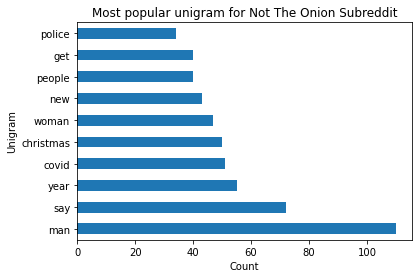

In [34]:
cvec = CountVectorizer()
not_the_onion_lem_title = cvec.fit_transform(nottheonion_df['lem_title'])
not_the_onion_lem_title_df = pd.DataFrame(not_the_onion_lem_title.toarray(), columns = cvec.get_feature_names())
not_the_onion_lem_title_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.ylabel('Unigram')
plt.xlabel('Count')
plt.title('Most popular unigram for Not The Onion Subreddit')

Text(0.5, 1.0, 'Most popular bigram for Not The Onion Subreddit')

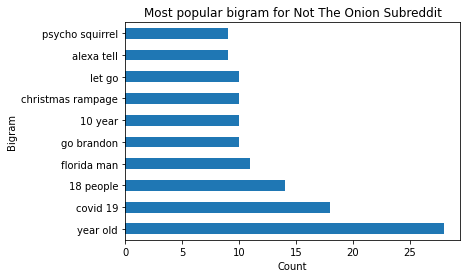

In [35]:
cvec_bi = CountVectorizer(ngram_range=(2,2))
not_the_onion_lem_title_bi = cvec_bi.fit_transform(nottheonion_df['lem_title'])
not_the_onion_lem_title_bi_df = pd.DataFrame(not_the_onion_lem_title_bi.toarray(), columns = cvec_bi.get_feature_names())
not_the_onion_lem_title_bi_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.ylabel('Bigram')
plt.xlabel('Count')
plt.title('Most popular bigram for Not The Onion Subreddit')

In [36]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('psycho squirrel') ,['title']]

,title
793,'Psycho' squirrel leaves 18 people injured in 48-hour rampage
803,'Psycho' squirrel on 48-hour rampage leaves 18 people injured
808,‘Psycho’ squirrel that went nuts biting residents is caught
809,'Psycho' squirrel's reign of terror ends after rampage left 18 people injured
870,"Bloodthirsty, 'Psycho' Squirrel Attacks 18 in Small Town Christmas Rampage"
889,"Bloodthirsty, ""psycho"" squirrel attacks 18 in small town Christmas rampage"
890,"‘Psycho’ squirrel’s 48-hour Christmas rampage terrorizes town, injures 18"
933,'Psycho' squirrel terrorizes small town over Christmas
964,"‘Psycho’ squirrel goes on 48-hour Christmas rampage in UK town, injures 18 people"


**Observation:** It seems that multiple users posted based on the same real world incident, which is a psycho squirrel attacking people.

In [37]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('alexa tell') ,['title']]

,title
604,Alexa tells 10-year-old girl to put penny in plug socket
697,Alexa tells 10-year-old girl to touch live plug with penny
729,Alexa tells girl to touch live plug with penny - BBC News
736,Amazon's Alexa Tells 10-year-old Girl To Put Penny in Plug Socket
750,Alexa tells girl to put penny in plug socket - BBC News
766,Amazon's Alexa tells 10-year-old child to touch penny to exposed plug socket
771,Alexa tells girl to touch live plug with penny
821,Amazon says it fixed an error that led Alexa to tell a 10-year-old girl to put a penny in an electrical outlet
954,Alexa Tells Child to Stick Penny on Exposed Socket


**Observation:** Multiple users posted based on the same real world incident, which is Alexa telling a child to stick a penny into an electrical plug socket.

In [38]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('let go') ,['title']]

,title
469,Parent Says 'Let's Go Brandon' During Biden Call With NORAD Santa Tracker
474,"On Santa tracking call, Biden is told 'Let's go Brandon' - and says he agrees"
485,"BREAKING: Biden says 'Let's go Brandon, I agree' during Christmas call with kids and parents"
505,Biden agrees with slogan 'Let's go Brandon'
520,"Dad tells Biden, 'Let's go Brandon' during Christmas Eve call — and Biden agrees"
554,NASCAR driver who unintentionally sparked 'Let’s Go Brandon' chant says corporations don’t want to sponsor him
583,‘Let’s go Brandon’ Santa Tracker caller insists he meant no disrespect to Biden | Joe Biden
642,"Man who used his freedom of speech in ""Let's go Brandon"" remark on phone call with Biden is upset that other people are using their freedom of speech against him"
927,'Let's Go Brandon' Crypto Coin to Sponsor 'Let's Go Brandon' Racecar Driver


**Observation:** These posts are based on the "Let's Go Brandon" meme. People against Joe Biden were chanting "Fuck Joe Biden" at a racing event. After professional racer Brandon Brown won the race, NBC reporter Kelli Stavast mistakenly described the chant as "Let's Go Brandon".

In [39]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('christmas rampage') ,['title']]

,title
760,‘Bloodthirsty’ squirrel attacks 18 people in Welsh village in two-day Christmas rampage
769,‘Bloodthirsty’ squirrel attacks 18 people in Welsh village in two-day Christmas rampage [X-post]
796,‘Bloodthirsty’ squirrel attacks 18 people in small Welsh village in two-day Christmas rampage
870,"Bloodthirsty, 'Psycho' Squirrel Attacks 18 in Small Town Christmas Rampage"
889,"Bloodthirsty, ""psycho"" squirrel attacks 18 in small town Christmas rampage"
890,"‘Psycho’ squirrel’s 48-hour Christmas rampage terrorizes town, injures 18"
951,"A squirrel went on a vicious Christmas rampage in a Welsh town, attacking 18 residents and animals"
963,"""Vicious"" Squirrel Attacks 18 People In Two-Day Christmas Rampage"
964,"‘Psycho’ squirrel goes on 48-hour Christmas rampage in UK town, injures 18 people"
979,Squirrel injures 18 people in Welsh town during two-day Christmas rampage


**Observation:** Basically the same posts as "psycho squirrel".

In [40]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('10 year') ,['title']]

,title
604,Alexa tells 10-year-old girl to put penny in plug socket
697,Alexa tells 10-year-old girl to touch live plug with penny
698,Alexa suggests 10-year-old put a penny on partially exposed plug
711,Amazon's Alexa 'fixed' after it tells 10-year-old girl to touch plug socket with penny | US News
735,Alexa challenges 10-year-old girl to put a penny in a plug
736,Amazon's Alexa Tells 10-year-old Girl To Put Penny in Plug Socket
766,Amazon's Alexa tells 10-year-old child to touch penny to exposed plug socket
798,Amazon's Alexa 'fixed' after it tells 10-year-old girl to touch plug socket with penny
816,Amazon's Alexa Says 10-year-old to touch Live Plug with Penny
821,Amazon says it fixed an error that led Alexa to tell a 10-year-old girl to put a penny in an electrical outlet


**Observation:** Basically the same posts as "alexa tell".

In [41]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('go brandon') ,['title']]

,title
469,Parent Says 'Let's Go Brandon' During Biden Call With NORAD Santa Tracker
474,"On Santa tracking call, Biden is told 'Let's go Brandon' - and says he agrees"
485,"BREAKING: Biden says 'Let's go Brandon, I agree' during Christmas call with kids and parents"
505,Biden agrees with slogan 'Let's go Brandon'
520,"Dad tells Biden, 'Let's go Brandon' during Christmas Eve call — and Biden agrees"
554,NASCAR driver who unintentionally sparked 'Let’s Go Brandon' chant says corporations don’t want to sponsor him
583,‘Let’s go Brandon’ Santa Tracker caller insists he meant no disrespect to Biden | Joe Biden
642,"Man who used his freedom of speech in ""Let's go Brandon"" remark on phone call with Biden is upset that other people are using their freedom of speech against him"
927,'Let's Go Brandon' Crypto Coin to Sponsor 'Let's Go Brandon' Racecar Driver


**Observation:** Basically the same posts as "let go".

In [42]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('florida man') ,['title']]

,title
180,Florida man banned from airline for wearing thong as mask compares himself to Rosa Parks
211,Florida man with drugs around penis denies they were his
242,"Florida man busted with meth and coke wrapped around his penis, tells cops it's not his"
257,Florida man with drugs around penis denies they were his | AP News
290,Florida Man With Drugs Around Penis Denies They Were His
295,"Florida man claims bags of cocaine, meth found wrapped around penis aren't his"
417,Florida man busted with drugs 'wrapped around his penis' tells deputies it's not his: report
452,Florida man busted with drugs 'wrapped around his penis' tells deputies it's not his
693,Florida Man Stabs Tourist Despite Having No Arms.
744,Wealthy Florida Man Murdered During Luxury Hotel Orgy


**Observation:** "Florida Man" is a meme from 2013 and repopularized in 2020. Florida is supposedly notorious for strange happenings and internet users post such reports, particularly those with "Florida Man" in the headline. 

In [43]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('18 people') ,['title']]

,title
760,‘Bloodthirsty’ squirrel attacks 18 people in Welsh village in two-day Christmas rampage
769,‘Bloodthirsty’ squirrel attacks 18 people in Welsh village in two-day Christmas rampage [X-post]
772,Squirrel injures 18 people in two days of attacks in Buckley
782,'Psycho' squirel on two-day rampage leaves 18 people injured
787,Squirrel injures 18 people in two days of attacks
793,'Psycho' squirrel leaves 18 people injured in 48-hour rampage
794,‘Bloodthirsty’ squirrel attacks 18 people in Welsh village
796,‘Bloodthirsty’ squirrel attacks 18 people in small Welsh village in two-day Christmas rampage
803,'Psycho' squirrel on 48-hour rampage leaves 18 people injured
809,'Psycho' squirrel's reign of terror ends after rampage left 18 people injured


**Observation:** Basically the same posts as "psycho squirrel".

In [44]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('covid 19') ,['title']]

,title
56,"Fox dropping COVID-19 testing option, requiring vaccinations for workers in New York"
86,Sarah Palin: 'Over my dead body' will I get the COVID-19 vaccine
162,"Slutcracker throws in the vibrator, cancels remainder of performances due to Covid-19"
177,The first American to die of the Omicron variant was an unvaccinated Texas man who had previously caught COVID-19
274,"Dozens at QAnon conference fall ill, swear it was an anthrax attack—not COVID-19"
312,North Carolina police chief placed on unpaid leave for telling officers about 'clinic' to obtain Covid-19 vaccination cards without getting the shots
313,"Covid-19: In Sweden, a vaccine passport on a microchip implant"
498,Amazon Yankee Candle reviews are mirroring the COVID-19 surge — again
506,Bidens blasted over singing nurses' WH performance as COVID-19 cases rise
573,A North Carolina police chief was put on unpaid leave after allegedly telling officers where they can get a COVID-19 vaccine card without the shot


**Observation:** A variety of posts regarding Covid 19. The posts are generally not related to each other.

In [45]:
nottheonion_df.loc[nottheonion_df['lem_title'].str.contains('year old') ,['title']]

,title
23,81-year-old US Capitol rioter sentenced to three years of probation
54,"A Theft Too Far – Akron police recover stolen bridge, arrest 63-year-old Medina Co. man"
134,6-year-old uses allowance to buy first home for $671K
142,"12-year-old tries to rob 17-year-old at gunpoint, gets shot instead, deputies say"
173,Six-year-old and her siblings buy house with pocket money
228,"21-year-old El Paso man jailed for allegedly posing as cop, trying to pull over vehicles"
240,40-year-old riding electric unicycle killed after being struck by car on H-1 Freeway
345,Warning against unnecessary circumcision from Australian Medical Association president Mark Duncan-Smith after two-year-old dies and brother almost bleeds out in Western Australia
445,Police find family of 2-year-old left at North Little Rock CiCi's Pizza
499,A chubby 2-year-old chain smoker who puffed 40 times a day looks unrecognizable in 7 years


**Observation:** A wide variety of posts that include people's age in the title. Includes the Alexa telling a child to stick a penny into an electrical plug socket posts.

Text(0.5, 1.0, 'Most popular trigram for Not The Onion Subreddit')

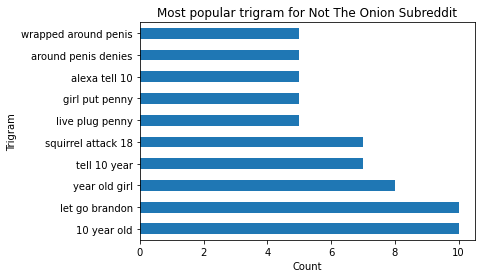

In [46]:
cvec_tri = CountVectorizer(ngram_range=(3,3))
not_the_onion_lem_title_tri = cvec_tri.fit_transform(nottheonion_df['lem_title'])
not_the_onion_lem_title_tri_df = pd.DataFrame(not_the_onion_lem_title_tri.toarray(), columns = cvec_tri.get_feature_names())
not_the_onion_lem_title_tri_df.sum().sort_values(ascending = False).head(10).plot(kind = 'barh')
plt.ylabel('Trigram')
plt.xlabel('Count')
plt.title('Most popular trigram for Not The Onion Subreddit')

**Observation:** Most popular trigrams are related to the popular posts identified in the most popular bigrams section.

- Florida Man posts: "wrapped around penis", "around penis denies"
- Alexa and penny in socket posts: "alexa tell 10", "girl put penny", "live plug penny", "tell 10 year", "year old girl", "10 year old"
- Psycho Squirrel posts: "squirrel attack 18"
- Let's Go Brandon posts: "let go brandon"

### Most Popular Ngram Insights
- The Onion has very little duplicated content, each post is usually a unique story
- Not The Onion has multiple users posting to the subreddit based on the same source story, using their own crafted post title 
- Popular topics covered by The Onion include: The Oscars 2021, Kyle Rittenhouse, Climate Change, Video Games
- Popular topics covered by Not The Onion include: Psycho Squirrel, Let's Go Brandon, Florida Man and Alexa and penny in socket

----
## Author post distribution in The Onion

In [47]:
theonion_df.groupby('author')['author'].count().sort_values(ascending=False)

author
dwaxe                   174
aresef                   86
Sanlear                  82
coolwali                 63
mothershipq              58
                       ... 
PapiSurane                1
ParticularScratch551      1
Pile_of_Walthers          1
PlayStationDERP           1
zorz_af                   1
Name: author, Length: 236, dtype: int64

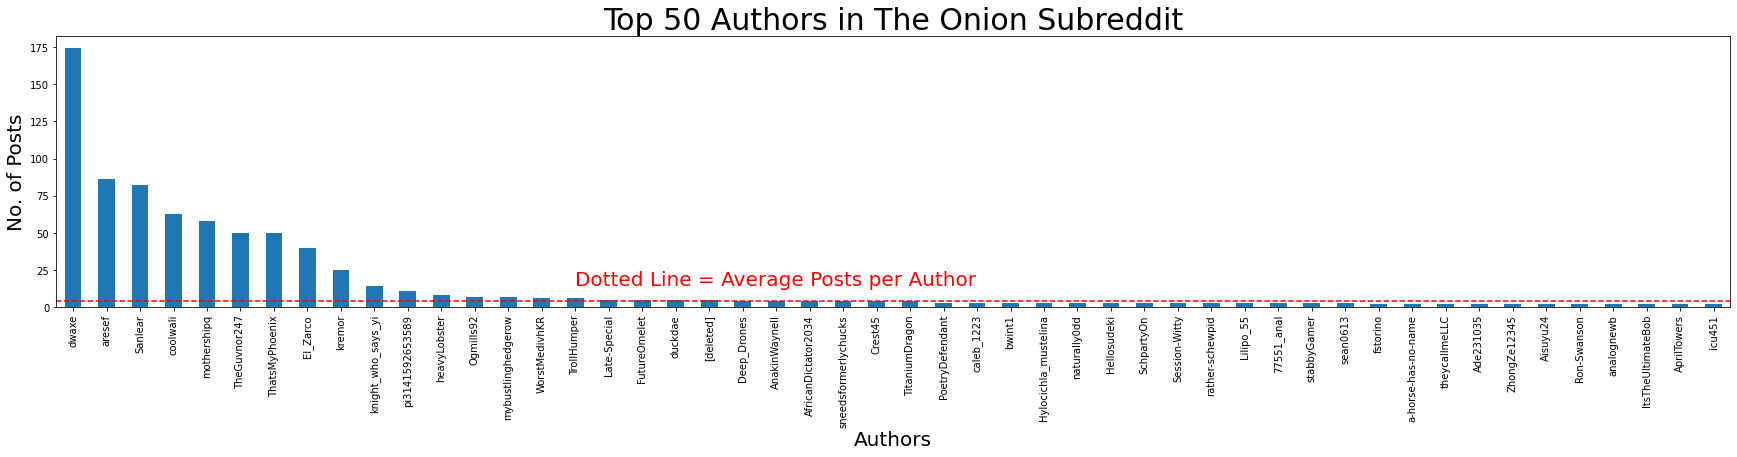

In [48]:
plt.figure(figsize = (30,5)) 
theonion_df.groupby('author')['author'].count().sort_values(ascending=False).head(50).plot(kind='bar')
plt.axhline(y=theonion_df.groupby('author')['author'].count().mean(), color='r', linestyle='--')
plt.title('Top 50 Authors in The Onion Subreddit',{'fontsize':30})
plt.xlabel('Authors',{'fontsize':20})
plt.ylabel('No. of Posts',{'fontsize':20})
plt.text(15,15,'Dotted Line = Average Posts per Author',{'fontsize':20},color='r')
plt.show()

In [49]:
theonion_df.groupby('author')['author'].count().describe()

count    236.000000
mean       4.237288
std       15.419898
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max      174.000000
Name: author, dtype: float64

**Observation:** Of the 1,000 scrapped posts from The Onion, there are 236 unique authors. On average, each author posts 4.24 posts.

**Insight:** Only a handful of authors are posting most of the posts in The Onion. This can be seen by the top few authors with post numbers way above the average number of posts per author (dotted red line). The author "dwaxe" has the most number of posts at 174, more than twice that of the 2nd place author "aresef" at 86 posts.

----
## Author post distribution in Not The Onion

In [50]:
nottheonion_df.groupby('author')['author'].count().sort_values(ascending=False)

author
virlan4trendnews        38
-Omegamart-             24
Darth_Kahuna            20
[deleted]               16
SelectiveSanity         15
                        ..
Reach-for-the-sky_15     1
RealTheAsh               1
Reasonable-Chemist16     1
Redbeard25               1
zwifter11                1
Name: author, Length: 718, dtype: int64

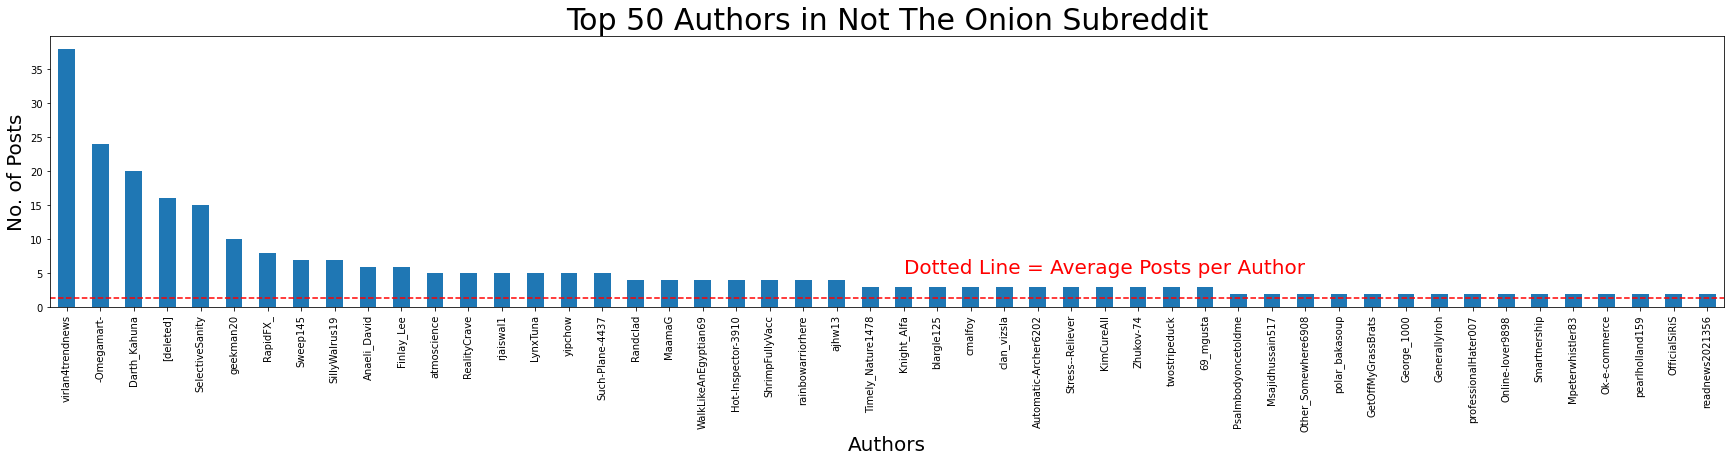

In [51]:
plt.figure(figsize = (30,5)) 
nottheonion_df.groupby('author')['author'].count().sort_values(ascending=False).head(50).plot(kind='bar')
plt.axhline(y=nottheonion_df.groupby('author')['author'].count().mean(), color='r', linestyle='--')
plt.title('Top 50 Authors in Not The Onion Subreddit',{'fontsize':30})
plt.xlabel('Authors',{'fontsize':20})
plt.ylabel('No. of Posts',{'fontsize':20})
plt.text(25,5,'Dotted Line = Average Posts per Author',{'fontsize':20},color='r')
plt.show()

In [52]:
nottheonion_df.groupby('author')['author'].count().describe()

count    718.000000
mean       1.392758
std        2.077052
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max       38.000000
Name: author, dtype: float64

**Observation:** Of the 1,000 scrapped posts from Not The Onion, there are 718 unique authors. On average, each author posts 1.39 posts.

**Insight:** Similar to The Onion, in Not The Onion, only a handful of authors are posting most of the posts. This can be seen by the top few authors with post numbers way above the average number of posts per author (dotted red line). The author "virlan4trendnews" has the most number of posts at 38, more than 1.5 times that of the 2nd place author "-Omegamart-" at 24 posts.

----
## Domain distribution in The Onion

In [53]:
theonion_df['domain'].value_counts(normalize = True)

theonion.com                  0.754
youtu.be                      0.035
entertainment.theonion.com    0.032
i.redd.it                     0.028
local.theonion.com            0.025
                              ...  
99funnews.com                 0.001
duffelblog.com                0.001
mirror.co.uk                  0.001
cnn.com                       0.001
theshovel.com.au              0.001
Name: domain, Length: 64, dtype: float64

In [54]:
theonion_df['domain'].describe()

count             1000
unique              64
top       theonion.com
freq               754
Name: domain, dtype: object

**Insight:** Vast majority of the posts in The Onion (75.4%) unsurprisingly come from theonion.com. There are 64 unique domains.

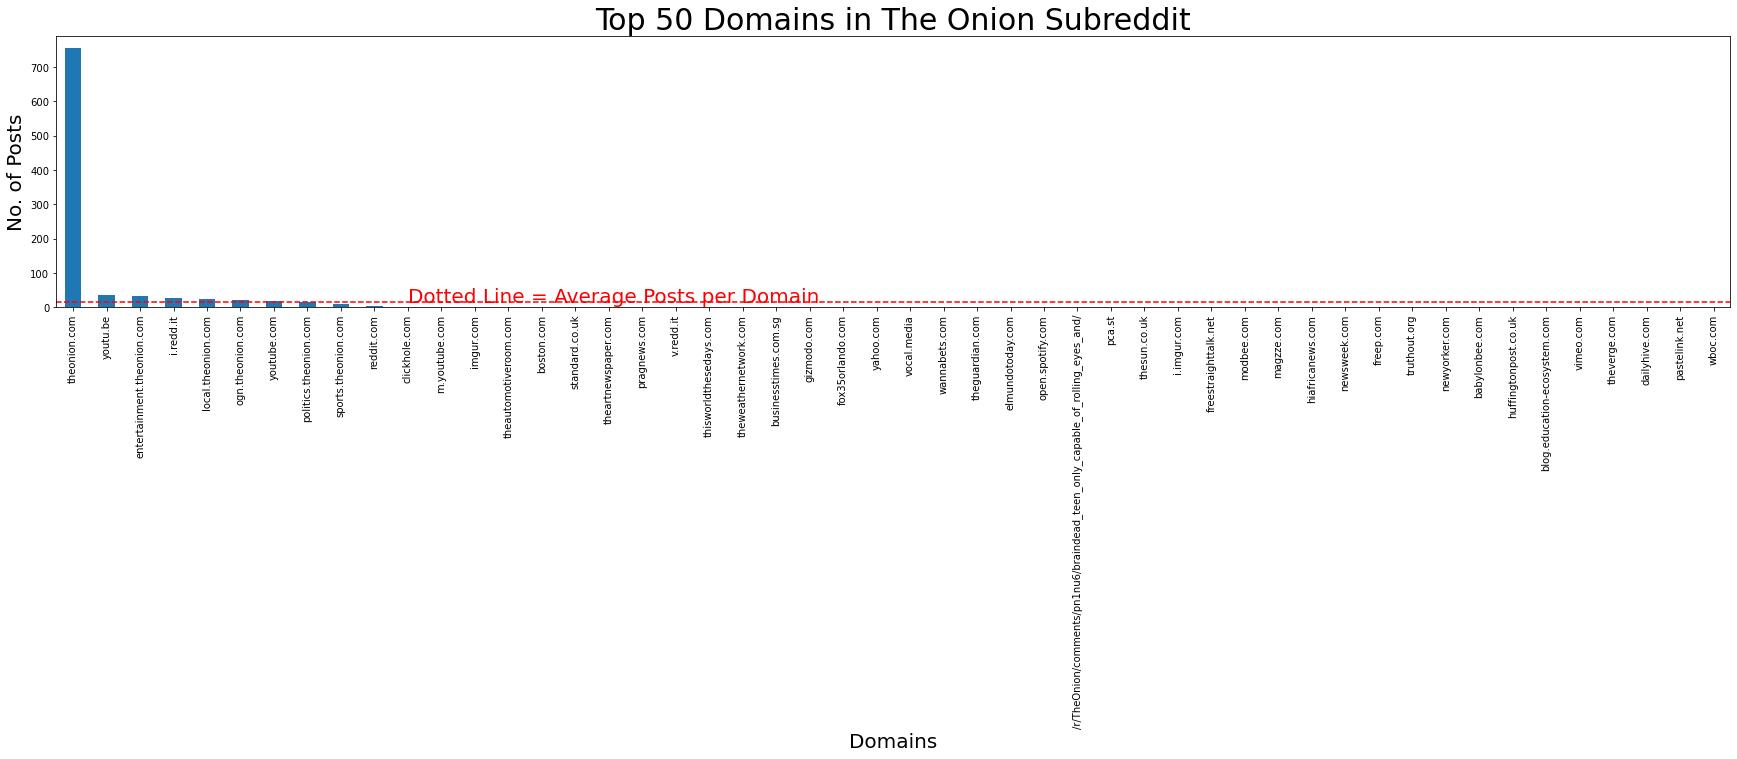

In [55]:
plt.figure(figsize = (30,5)) 
theonion_df['domain'].value_counts().head(50).plot(kind='bar')
plt.axhline(y=theonion_df['domain'].value_counts().mean(), color='r', linestyle='--')
plt.title('Top 50 Domains in The Onion Subreddit',{'fontsize':30})
plt.xlabel('Domains',{'fontsize':20})
plt.ylabel('No. of Posts',{'fontsize':20})
plt.text(10,15,'Dotted Line = Average Posts per Domain',{'fontsize':20},color='r')
plt.show()

**Insight:** The top domain, theonion.com is heads and shoulders above every other domain. This is consistent with the subreddit rules of only allowing posts from theonion.com. Posts from the other domains are likely to have been removed.

----
## Domain distribution in Not The Onion

In [56]:
nottheonion_df['domain'].value_counts(normalize = True)

virlan.co             0.037
theguardian.com       0.030
bbc.com               0.021
foxnews.com           0.021
youtu.be              0.020
                      ...  
publicfigure.com      0.001
dailymotion.com       0.001
driving.ca            0.001
staradvertiser.com    0.001
shrinke.me            0.001
Name: domain, Length: 487, dtype: float64

In [57]:
nottheonion_df['domain'].describe()

count          1000
unique          487
top       virlan.co
freq             37
Name: domain, dtype: object

**Insight:** Compared to The Onion, Not The Onion does not have a standout domain. The top domain, virlan.co is only at 3.7% compared to theonion.com's 75.4%. The number of unique domains are 487, which is more than 7 times that of The Onion.

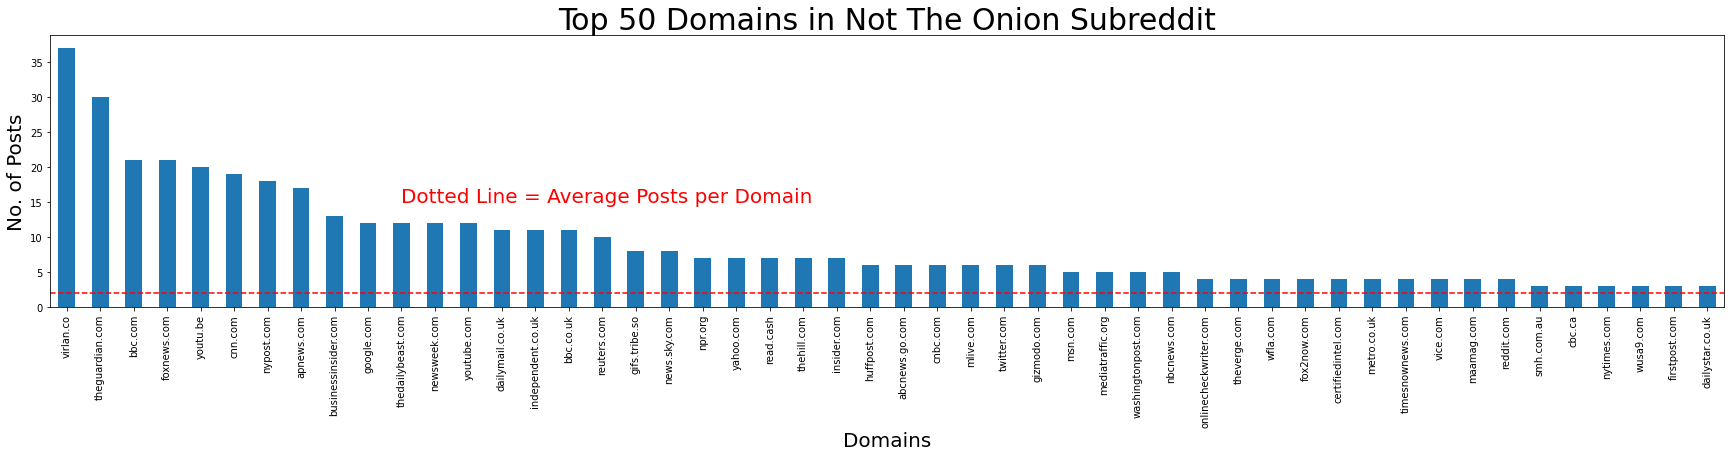

In [58]:
plt.figure(figsize = (30,5)) 
nottheonion_df['domain'].value_counts().head(50).plot(kind='bar')
plt.axhline(y=nottheonion_df['domain'].value_counts().mean(), color='r', linestyle='--')
plt.title('Top 50 Domains in Not The Onion Subreddit',{'fontsize':30})
plt.xlabel('Domains',{'fontsize':20})
plt.ylabel('No. of Posts',{'fontsize':20})
plt.text(10,15,'Dotted Line = Average Posts per Domain',{'fontsize':20},color='r')
plt.show()

**Insight:** The posts in the Not The Onion subreddit are spread across a much larger number of domains compared to The Onion subreddit.

----
## Feature Comparison between the 2 subreddits
Combining datasets of both subreddits

In [59]:
theonion_df['onion'] = 1
nottheonion_df['onion'] = 0

In [60]:
combined_df = pd.concat(objs = [theonion_df,nottheonion_df])
combined_df[['lem_title','onion']].head()

,lem_title,onion
0,abby lee miller cancer,1
1,amazon celebrates union defeat raising price 150 anyway,1
2,new arkansas bill would require teen resident keep genitals full display time,1
3,way prevent say nation regularly happens,1
4,panther adopt patchy haired shivering rescue qb spent year abused jet,1


In [61]:
combined_df[['lem_title','onion']].tail()

,lem_title,onion
995,call thespian actor say nicolas cage,0
996,giuffre lawyer seek detail prince andrew claimed inability sweat,0
997,betty white dead 99,0
998,central texas red cross sending least one volunteer colorado devastating fire,0
999,virginia giuffre lawyer demand proof prince andrew sweat,0


Some interesting features to look at across the 2 subreddits:
- total_awards_received: how many awards did a post receive from other redditors 
- num_comments: how many comments were in the post
- upvote_ratio: percentage of upvotes out of total votes (upvotes + downvotes)
- over_18: whether the post was classified as over 18 content

In [62]:
interesting_features = ['total_awards_received','num_comments','upvote_ratio','over_18']
combined_df.groupby('onion')[interesting_features].mean()

,total_awards_received,num_comments,upvote_ratio,over_18
onion,,,,
0,0.000,0.344,0.99997,0.007
1,0.003,5.612,0.99705,0.013


**Insights:** 
- total_awards_received: Not The Onion posts get almost no awards on average while The Onion has a negligible number of awards
- num_comments: The Onion posts on average get 16 times the number of comments of Not The Onion posts
- upvote_ratio: Posts from both subreddits are generally very upvoted at more than 99%, negligible difference
- over_18: Although both subreddits have a low number of over 18 posts, The Onion has almost twice as many of such posts as Not The Onion

Text(0.5, 0, 'No. of removed posts')

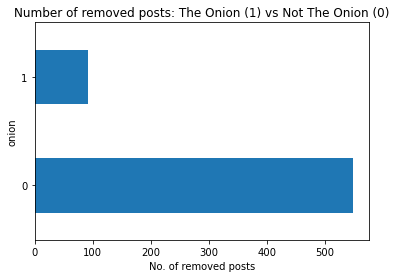

In [63]:
combined_df.groupby('onion')['removed_by_category'].count().plot(kind='barh')
plt.title('Number of removed posts: The Onion (1) vs Not The Onion (0)')
plt.xlabel('No. of removed posts')

**Insights:**
- More than half of the posts from Not The Onion have been removed (549 out of 1,000 posts)
- This is compared to only 92 out of 1,000 from The Onion

In [64]:
theonion_df['removed_by_category'].value_counts(normalize = True)

moderator    0.891304
reddit       0.054348
deleted      0.054348
Name: removed_by_category, dtype: float64

In [65]:
nottheonion_df['removed_by_category'].value_counts(normalize = True)

moderator           0.728597
reddit              0.174863
automod_filtered    0.069217
deleted             0.027322
Name: removed_by_category, dtype: float64

**Insights:**
- Vast majority of the posts are removed by human moderators. 89.1% for The Onion and 72.9% for Not The Onion.
- 6.92% of the removed posts from Not The Onion comes from an automoderator with rules set by the human moderators. The Onion does not have posts removed by an automoderator.
- From the large difference between the percentage of posts removed by human moderators vs automoderators, developing a more efficient automoderator will greatly aid the work of the human moderators. 

----
## Export Data
Export data to be used in the final notebook

In [66]:
theonion_df.to_csv('../data/the_onion_lem.csv', index = False)
nottheonion_df.to_csv('../data/not_the_onion_lem.csv', index = False)